In [1]:
import sys
import os

# Fix relative import issue, append root path to sys.path
parent = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent)

In [ ]:
from core.dataset import MoleculeDataset
from core.trainer import ModelTrainer
from core.dataset import RawDatasetList
from models import SimpleMoleculeGCN, AdvancedMoleculeGNN

from typing import Tuple, Dict 
import torch

from core.utils import set_seed, count_parameters, load_dataset, create_data_loaders
from core.evaluator import plot_training_history

In [4]:
set_seed()

In [ ]:
# contains map of { csv_file_path : (smiles_col, target_col)}
_dataset_column_map: Dict[RawDatasetList, Tuple[str, str]] = {
    RawDatasetList.ESOL :  ("smiles", "ESOL predicted log solubility in mols per litre"), 
    RawDatasetList.FREESOLV: ("smiles", "calc"), 
    RawDatasetList.LIPOPHILICITY: ("smiles", "exp")
}

def dataset_loader_from_map(dataset: RawDatasetList): 
    csv_path: str = "../data/raw/" + dataset.value
    smile_col = _dataset_column_map[dataset][0]
    target_col = _dataset_column_map[dataset][1]
    return load_dataset(
        csv_path, 
        smiles_col=smile_col, 
        target_col=target_col
    )


In [ ]:
dataset = dataset_loader_from_map(RawDatasetList.ESOL)

In [10]:
train_loader, val_loader, test_loader = create_data_loaders(dataset)

In [11]:
num_node_features = MoleculeDataset._N_NODE_FEATURES  # Based on get_atom_features (grabbed only 6 feature, have to increase)
num_edge_feature = MoleculeDataset._N_EDGE_FEATURES  

modelGCN = SimpleMoleculeGCN(
    num_node_features=num_node_features,
    hidden_dim=128,
    num_classes=1
)

modelGNN = AdvancedMoleculeGNN(
    num_node_features=num_node_features,
    num_edge_features=num_edge_feature, 
    hidden_dim=128,
    num_classes=1
)

model = modelGNN
model_list = [modelGCN, modelGNN]

[count_parameters(model) for model in model_list]

[43009, 93057]

In [ ]:
trainer = ModelTrainer(model)
trainer.fit(
    train_loader, 
    val_loader, 
    epochs=5, 
    lr=0.001,
    task='regression',
    patience=15
)

criterion = torch.nn.BCEWithLogitsLoss()
test_loss, test_metric, metric_name = trainer.evaluate(test_loader, criterion, 'classification')
print(f'\nTest Results: Loss: {test_loss:.4f}, {metric_name}: {test_metric:.4f}')

Training: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


Epoch 001: Train Loss: 561069350.7326, Val Loss: 203690961.7778, Val RMSE: 14272.0342


Training: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


Epoch 002: Train Loss: 180776168.5779, Val Loss: 137775312.0000, Val RMSE: 11737.7725


Training: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


Epoch 003: Train Loss: 93578051.9949, Val Loss: 48132653.7778, Val RMSE: 6937.7700


Training: 100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Epoch 004: Train Loss: 61893921.8099, Val Loss: 34390424.2222, Val RMSE: 5864.3350


Training: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


Epoch 005: Train Loss: 40577942.0076, Val Loss: 32684003.1111, Val RMSE: 5716.9922
Training completed. Best validation loss: 32684003.1111

Test Results: Loss: -19135.1175, ROC-AUC: 0.5000


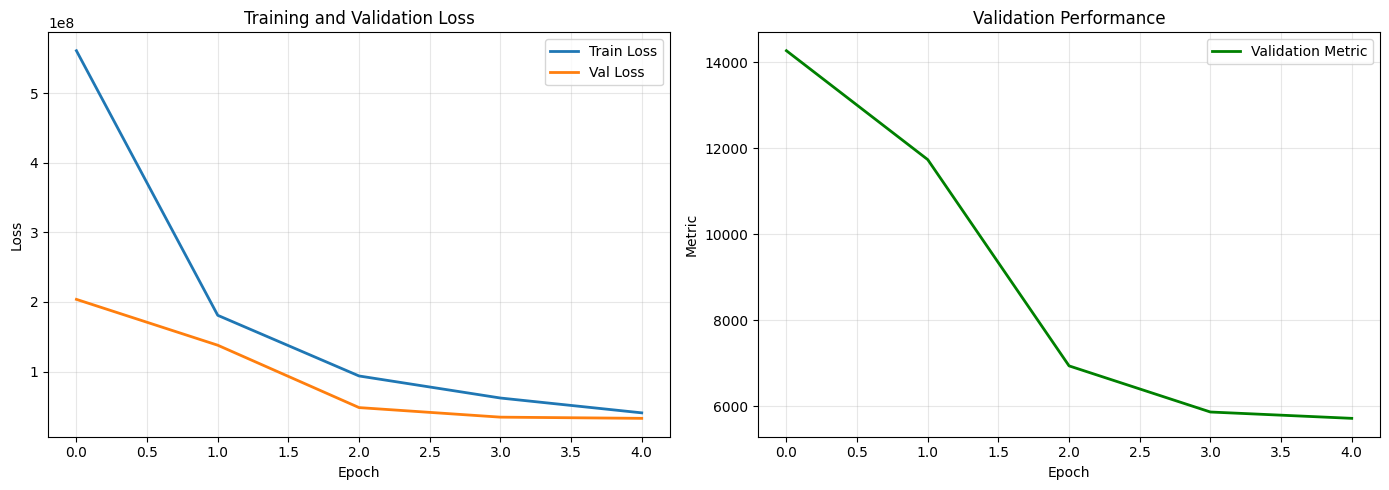

In [16]:
plot_training_history(trainer.history)